In [1]:
import jax.numpy as jnp
import jax
import pandas as pd
import numpy as np
import pyreadr

from numpyro.infer import SVI, Trace_ELBO
from numpyro.optim import ClippedAdam
from numpyro.infer.autoguide import AutoMultivariateNormal
import numpyro.distributions as dist
import numpyro

import src.utils as utils

import os 

import Data.Palluck_et_al.data_wrangle as dw

# --- Set cores and seed ---
N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"


In [2]:
all_schools = pyreadr.read_r('Data/Palluck_et_al/37070-0001-Data.rda')
all_schools = pd.DataFrame(all_schools['da37070.0001'])

df_cleaned = dw.clean_data(all_schools)

print(df_cleaned.shape)
print(df_cleaned.columns)

(24182, 41)
Index(['SCHID', 'SCHTREAT_NUMERIC', 'TREAT_NUMERIC', 'unique_id', 'ELIGIBLE',
       'WRISTOW2_NUMERIC', 'ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7',
       'ST8', 'ST9', 'ST10', 'ST1W2', 'ST2W2', 'ST3W2', 'ST4W2', 'ST5W2',
       'ST6W2', 'ST7W2', 'ST8W2', 'ST9W2', 'ST10W2', 'BF1', 'BF2', 'BF1W2',
       'BF2W2', 'GENC', 'ETHW', 'ETHB', 'ETHH', 'ETHA', 'ETHC', 'ETHSA',
       'GAME', 'GRC_6', 'GRC_7', 'GRC_8'],
      dtype='object')


In [3]:
# test one school

df_min = df_cleaned[df_cleaned['SCHID'] == 41.0]
print(df_min.shape)

(503, 41)


In [4]:

triu_idx = np.triu_indices(df_min.shape[0], 1)

# ST net
st_net = dw.network_by_school(df_min, dw.ST_COLS, False)
st_net_triu = jnp.array(st_net[triu_idx], dtype=jnp.float32)

# ST_w2 net 

stw2_net = dw.network_by_school(df_min, dw.ST_W2_COLS, False)
stw2_net_triu = jnp.array(stw2_net[triu_idx], dtype=jnp.float32)

# BF net

bf_net = dw.network_by_school(df_min, dw.BF_COLS, False)
bf_net_triu = jnp.array(bf_net[triu_idx], dtype=jnp.float32)

# BF_w2 net

bfw2_net = dw.network_by_school(df_min, dw.BF_W2_COLS, False)
bfw2_net_triu = jnp.array(bfw2_net[triu_idx], dtype=jnp.float32)

print(st_net_triu.shape, stw2_net_triu.shape, bf_net_triu.shape, bfw2_net_triu.shape)

(126253,) (126253,) (126253,) (126253,)


In [ ]:
NODE_COV = ["GENC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA", "GAME", "GRC_6", "GRC_7", "GRC_8"]
df_min_node_cov = jnp.array(df_min[NODE_COV])
print(df_min_node_cov.shape)


(503, 11)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]]


In [102]:
def cov_for_net(df, cov_name_list):
    idx = jnp.triu_indices(n=df.shape[0], k=1)
    # x2_or = (x2[idx[0]] + x2[idx[1]] == 1).astype(jnp.float32)
    cov_list = [jnp.ones(idx[0].shape[0])]
    for cov in cov_name_list:
        cur_cov = jnp.all(df[cov].values[idx[0]] == df[cov].values[idx[1]], axis=1).astype(jnp.float32)
        cov_list.append(cur_cov)
    return jnp.stack(cov_list, axis=1)

In [101]:
cv = ["GENC"]
# cv = ["ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA"]

idx = jnp.triu_indices(n=df_min.shape[0], k=1)

jnp.all(df_min[cv].values[idx[0]] == df_min[cv].values[idx[1]], axis=1).astype(jnp.float32).mean()
# (df_min["GENC"].values[idx[0]] == df_min["GENC"].values[idx[1]]).astype(jnp.float32).mean()

Array(0.499101, dtype=float32)

In [103]:
# df_min_net_cov = cov_for_net(df_min, NODE_COV)
df_min_net_cov = cov_for_net(df_min, dw.COV_FOR_NETWORK)

print(df_min_net_cov.shape, df_min_net_cov.dtype, type(df_min_net_cov))

(126253, 5) float32 <class 'jaxlib.xla_extension.ArrayImpl'>


In [154]:
PRIOR_SCALE = jnp.sqrt(5.0)

def networks_marginalized_model(data):
    """
    Model for network only models with marginalized A*
    Used in cut-posterior sampling

    We embed it as mixture model of A edges

    Args:
      data: an object with attributes:
           - x_diff: a 1D array (one per edge) of differences in covariates,
           - x2_or: a 1D array of indicators (one per edge) for whether x2_i + x2_j = 1,
           - triu_obs: a 1D array of observed edge indicators (binary; one per edge).
    """
    # --- Priors ---

    with numpyro.plate("latent_u", data["n"]):
        # u = numpyro.sample("u", dist.Normal(0, 1))
        u = numpyro.sample("u", dist.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))

    idx = np.triu_indices(n=data["n"], k=1)
    u_diff = u[idx[0]] - u[idx[1]]
    u_norm = jnp.linalg.norm(u_diff, axis=1)

    n_cols = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([n_cols]))
    # with numpyro.plate("theta_plate", n_cols):
        # theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE))
    
    # with numpyro.plate("gamma_plate", n_cols + 1):
        # gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE))

        # P(A*_ij=1)
    gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2*n_cols]))
    # gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2]))

        # P(A*_ij=1)
    # star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_diff)
    star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_norm)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 0)
    # obs_probs_k0 = jax.nn.sigmoid(data["cov"] @ gamma[1:])
    obs_probs_k0 = jax.nn.sigmoid(data["cov"] @ gamma[:n_cols])
    # obs_probs_k0 = jax.nn.sigmoid(gamma[0])
    obs_probs_k0 = jnp.clip(obs_probs_k0, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 1)
    # obs_probs_k1 = jax.nn.sigmoid(gamma[0] + data["cov"] @ gamma[1:])
    obs_probs_k1 = jax.nn.sigmoid(data["cov"]  @ gamma[n_cols:])
    # obs_probs_k1 = jax.nn.sigmoid(gamma[1])
    obs_probs_k1 = jnp.clip(obs_probs_k1, 1e-6, 1 - 1e-6)

    # marginalized probs P(A_ij=1)
    mixed_probs = star_probs * obs_probs_k1 + (1 - star_probs) * obs_probs_k0

    with numpyro.plate("edges", data["STW2_triu"].shape[0]):
        numpyro.sample("obs", dist.BernoulliProbs(mixed_probs), obs=data["STW2_triu"])

    # save posterior A_star probs
    # let  p_1 = P(A*_ij=1)*P(A_ij| A*_ij=1)
    #      p_0 = P(A*_ij=0 )*P(A_ij| A*_ij=0)
    # then posterior probs P(A*_ij | A, \theta,\ gamma) = p_1 / (p_1 + p_0)

    # numerator aka p_1
    numerator = jnp.where(
        data["STW2_triu"] == 1.0, star_probs * obs_probs_k1, star_probs * (1 - obs_probs_k1)
    )
    # denominator aka p_1 + p_0
    denominator = numerator + jnp.where(
        data["STW2_triu"] == 1.0,
        (1 - star_probs) * obs_probs_k0,
        (1 - star_probs) * (1 - obs_probs_k0),
    )

    numpyro.deterministic("triu_star_probs", numerator / denominator)



In [71]:
theta = jnp.ones(df_min_net_cov.shape[1])
gamma = jnp.ones(2*df_min_net_cov.shape[1])


(df_min_net_cov @ theta).shape, jnp.dot(df_min_net_cov, gamma[:df_min_net_cov.shape[1]]).shape

((126253,), (126253,))

In [73]:
gamma[df_min_net_cov.shape[1]:].shape 

(12,)

In [74]:
a = [1,2,3,4,5,6,7,8,9,10]

a[:5], a[5:]

([1, 2, 3, 4, 5], [6, 7, 8, 9, 10])

In [135]:
data_st = {"STW2_triu": stw2_net_triu,
            "cov": df_min_net_cov,
            "ST_triu" : st_net_triu,
            "BF_triu" : bf_net_triu,
            "BFW2_triu" : bfw2_net_triu,
            "n" : df_min.shape[0]}

In [110]:
print(data_st["STW2_triu"].shape, data_st["cov"].shape)

(126253,) (126253, 5)


In [155]:
init_vals = {
    "theta": jnp.zeros(data_st["cov"].shape[1]),
    # "gamma": jnp.zeros(data_st["cov"].shape[1] + 1),
    "gamma": jnp.zeros(2*data_st["cov"].shape[1]),
    # "gamma": jnp.zeros(2),
}

guide = AutoMultivariateNormal(networks_marginalized_model)

svi = SVI(
    model=networks_marginalized_model,
    guide=guide,
    optim=ClippedAdam(0.0005),
    loss=Trace_ELBO(),
)

rng_key = jax.random.PRNGKey(0)
rng_key, _ = jax.random.split(rng_key)

svi_result = svi.run(rng_key=rng_key,
                    num_steps=20000,
                    progress_bar=True,
                    data=data_st,
                    init_params=init_vals)
map_params = guide.median(svi_result.params)

print(map_params)

100%|██████████| 20000/20000 [17:05<00:00, 19.50it/s, init loss: 98561.1172, avg. loss [19001-20000]: 10309.0474]


{'u': Array([[ 0.00190367,  0.00616967],
       [ 0.03460601,  0.03233643],
       [-0.04327706,  0.0145499 ],
       ...,
       [-0.0081852 ,  0.01111579],
       [-0.0161706 , -0.03076095],
       [-0.01511599,  0.01175062]], dtype=float32), 'theta': Array([ 3.695182  ,  0.4391562 , -0.17172164, -0.01959702,  3.2938807 ],      dtype=float32), 'gamma': Array([-2.7513564 , -2.9073784 ,  0.16992389, -0.04496252, -2.0303812 ,
       -5.2064357 ,  0.949013  , -0.03599646,  0.0482372 ,  0.7843366 ],      dtype=float32), 'triu_star_probs': Array([0.9999872 , 0.99934554, 0.9993675 , ..., 0.9799663 , 0.9806546 ,
       0.9992266 ], dtype=float32)}


In [156]:
from numpyro.infer import Predictive

rng_key, _ = jax.random.split(rng_key)
preds = Predictive(
    model=networks_marginalized_model,
    guide=guide,
    params=svi_result.params,
    num_samples=1,
)(rng_key, data_st)

triu_star_probs = preds["triu_star_probs"][0]
print(triu_star_probs.shape)

(126253,)


(array([4.9000e+01, 8.1000e+01, 8.8000e+01, 1.0700e+02, 1.4900e+02,
        1.9200e+02, 2.3500e+02, 3.0500e+02, 3.8900e+02, 4.5700e+02,
        6.8800e+02, 9.0400e+02, 1.3150e+03, 1.7880e+03, 2.6000e+03,
        4.0870e+03, 6.8250e+03, 1.2512e+04, 2.6696e+04, 6.6786e+04]),
 array([0.00394941, 0.05375159, 0.10355378, 0.15335597, 0.20315816,
        0.25296035, 0.30276254, 0.35256472, 0.40236691, 0.45216909,
        0.5019713 , 0.55177349, 0.60157567, 0.65137786, 0.70118004,
        0.75098222, 0.80078441, 0.85058659, 0.90038878, 0.95019096,
        0.99999315]),
 <BarContainer object of 20 artists>)

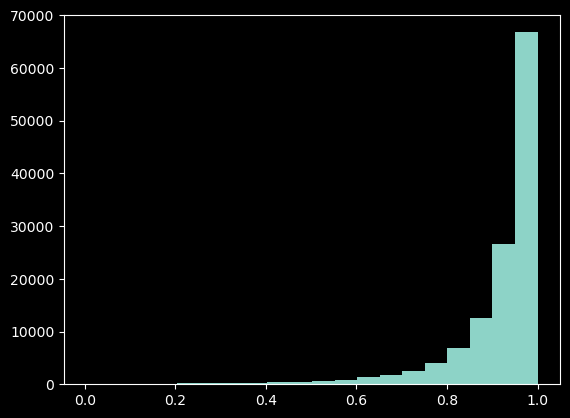

In [157]:
import matplotlib.pyplot as plt
plt.hist(triu_star_probs, bins=20)

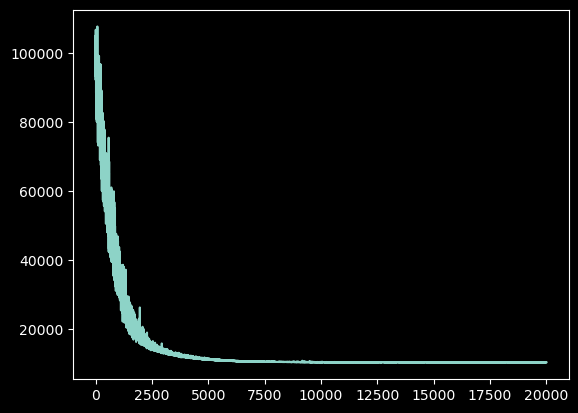

In [158]:
plt.plot(svi_result.losses)

In [159]:
from src.MWG_sampler import sample_posterior_triu_star

rng_key, _ = jax.random.split(rng_key)
post_triu = sample_posterior_triu_star(rng_key, triu_star_probs, 3000)
print(post_triu.shape)

(3000, 126253)


In [163]:
true_deg = jnp.sum(st_net, axis=1)
stw2_deg = jnp.sum(stw2_net, axis=1)
bf_deg = jnp.sum(bf_net, axis=1)
N = df_min.shape[0]

@jax.jit
def triu_to_mat(triu):
    mat = jnp.zeros((N, N))
    mat = mat.at[np.triu_indices(n=N, k=1)].set(triu)
    return mat + mat.T

@jax.jit
def compute_deg(triu):
    mat = triu_to_mat(triu)
    return jnp.sum(mat, axis=1)

vmap_deg = jax.vmap(compute_deg)

post_deg = vmap_deg(post_triu)

print(post_deg.shape)


# plt.scatter(true_deg, stw2_deg)


(3000, 503)


cor ST and ST w2 0.2918907
cor ST and Post 0.032520775
cor ST w2 and BF 0.31267422


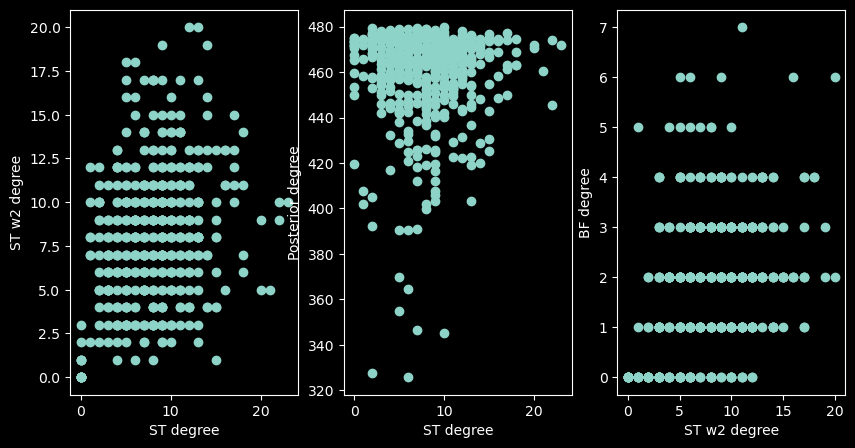

In [164]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].scatter(true_deg, stw2_deg)
axs[0].set_xlabel("ST degree")
axs[0].set_ylabel("ST w2 degree")

axs[1].scatter(true_deg, post_deg.mean(axis=0))
axs[1].set_xlabel("ST degree")
axs[1].set_ylabel("Posterior degree")

axs[2].scatter(stw2_deg, bf_deg)
axs[2].set_xlabel("ST w2 degree")
axs[2].set_ylabel("BF degree")

print("cor ST and ST w2", jnp.corrcoef(true_deg, stw2_deg)[0, 1])
print("cor ST and Post", jnp.corrcoef(true_deg, post_deg.mean(axis=0))[0, 1])
print("cor ST w2 and BF", jnp.corrcoef(stw2_deg, bf_deg)[0, 1])

In [ ]:
# TODO: keep tinkering. options:
# 1. Run models with known st_triu values and perform posterior predictive checks for model fit
# 2. Run model with combined st_w2 and bf proxy networks -- think about these models form and prior p(ST) model 